In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [65]:
df = pd.read_json("clean_dataset_3inpclass.json")

In [66]:
df.sample(3)

,id,elapsed_sec,output,model,type
6982,/home/harinarayan.j/human_vs_machine/train-dir...,4.853864,"On an autumnal evening, a crisply chilled one,...",mistral,mw_mh
10303,/home/harinarayan.j/human_vs_machine/train-dir...,6.065302,It’s mind-boggling how far Trump has strayed f...,llama,mw_mh
14830,/home/harinarayan.j/human_vs_machine/train-dir...,4.391844,What would have happened if I had known of Mr....,llama,mw_mh


In [67]:
df.drop(['id', 'elapsed_sec'], axis=1, inplace=True)
df.sample(3)

,output,model,type
59947,It's been an strange week in philanthropic cir...,llama,hw_mp
51063,``` Eary Game Boosts value you get fom finishi...,llama,hw_mp
13673,Johnnie Depp's breakout performance in the act...,llama,mw_mh


In [68]:
cols = df.columns.tolist()
cols[1], cols[2] = cols[2], cols[1]
df = df[cols]

In [69]:
df.sample(3)

,output,type,model
33465,With today's consumer expecting more from onli...,hw_mp,mistral
4542,"On this significant day, we come together in u...",mw_mh,mistral
47933,Scholarly research into what works in educatio...,hw_mp,llama


In [70]:
df.shape

(73727, 3)

In [71]:
df = df.sample(frac=1)

In [52]:
df.shape

(73884, 3)

In [73]:
df.sample(5)

,output,type,model
71283,"In a surprising turn of events, a newly discov...",mw,llama
65453,"March dawned brightly in Medina, casting shado...",mw,llama
10459,Tucked in a secluded corner of our country lie...,mw_mh,llama
22402,NHL fans eagerly await the reveal of the updat...,mw,mistral
6670,Caught in a disagreement with his own party ag...,mw_mh,mistral


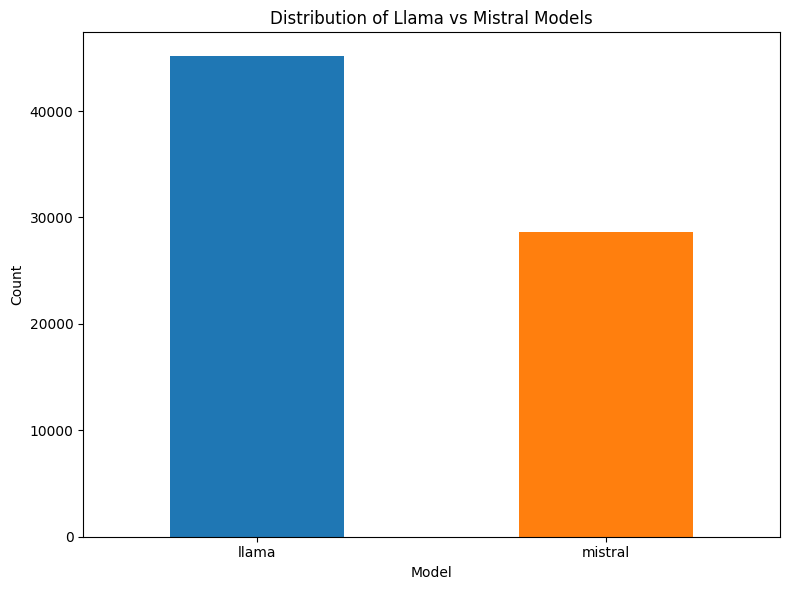

model
llama      45135
mistral    28592
Name: count, dtype: int64


In [74]:
model_counts = df['model'].value_counts()

plt.figure(figsize=(8, 6))
model_counts.plot(kind='bar', color=['#1f77b4', '#ff7f0e'])
plt.title('Distribution of Llama vs Mistral Models')
plt.xlabel('Model')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print(model_counts)

In [75]:
import pandas as pd

counts = df['model'].value_counts()
print(counts)

min_count = counts.min()

df_balanced = df.groupby('model', group_keys=False).apply(
    lambda x: x.sample(n=min_count, random_state=42)
).reset_index(drop=True)

print(df_balanced['model'].value_counts())


model
llama      45135
mistral    28592
Name: count, dtype: int64
model
llama      28592
mistral    28592
Name: count, dtype: int64


C:\Users\Venkat\AppData\Local\Temp\ipykernel_32492\3520079534.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('model', group_keys=False).apply(


In [76]:
df = df_balanced

In [77]:
df.shape

(57184, 3)

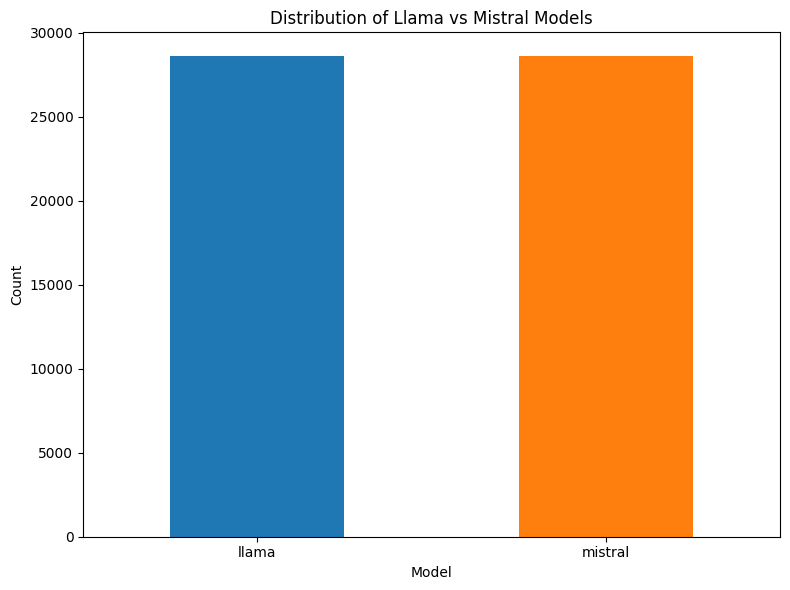

model
llama      28592
mistral    28592
Name: count, dtype: int64


In [78]:
model_counts = df['model'].value_counts()

plt.figure(figsize=(8, 6))
model_counts.plot(kind='bar', color=['#1f77b4', '#ff7f0e'])
plt.title('Distribution of Llama vs Mistral Models')
plt.xlabel('Model')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print(model_counts)

Training Logistic Regression...
Training Random Forest...
Training XGBoost...
Training LightGBM...


c:\Users\Venkat\nlp_llm\env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



MODEL COMPARISON RESULTS
              Model  Accuracy  Precision  Recall  F1-Score
Logistic Regression    0.8863     0.8865  0.8863    0.8863
      Random Forest    0.8252     0.8252  0.8252    0.8252
            XGBoost    0.8674     0.8674  0.8674    0.8674
           LightGBM    0.8698     0.8700  0.8698    0.8698


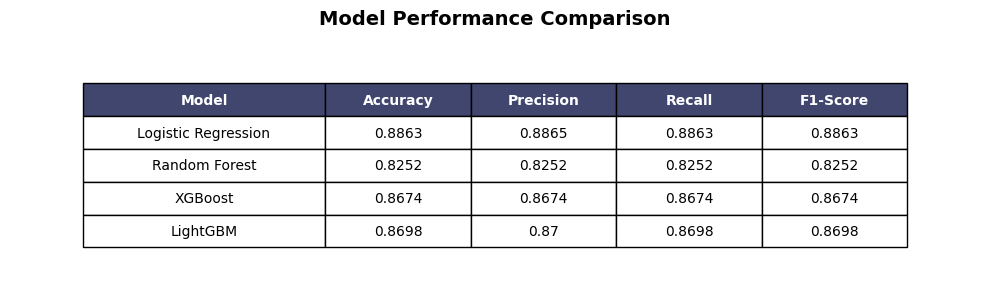

In [79]:
# with both output and type
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

le_type = LabelEncoder()
df['type'] = le_type.fit_transform(df['type'])

le_model = LabelEncoder()
df['model'] = le_model.fit_transform(df['model'])

X_text = df['output']
X_type = df['type']
y = df['model']

X_train_text, X_test_text, X_train_type, X_test_type, y_train, y_test = train_test_split(
    X_text, X_type, y, test_size=0.2, random_state=42, stratify=y
)

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)

X_train = np.hstack([X_train_tfidf.toarray(), X_train_type.values.reshape(-1, 1)])
X_test = np.hstack([X_test_tfidf.toarray(), X_test_type.values.reshape(-1, 1)])

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1)
}

results = []

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

results_df = pd.DataFrame(results)
results_df = results_df.round(4)

print("\n" + "="*70)
print("MODEL COMPARISON RESULTS")
print("="*70)
print(results_df.to_string(index=False))
print("="*70)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 3))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=results_df.values, 
                colLabels=results_df.columns,
                cellLoc='center',
                loc='center',
                colWidths=[0.25, 0.15, 0.15, 0.15, 0.15])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

for i in range(len(results_df.columns)):
    table[(0, i)].set_facecolor('#40466e')
    table[(0, i)].set_text_props(weight='bold', color='white')

plt.title('Model Performance Comparison', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

Training Logistic Regression...
Training Random Forest...
Training XGBoost...
Training LightGBM...


c:\Users\Venkat\nlp_llm\env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



MODEL COMPARISON RESULTS (WITHOUT 'type')
              Model  Accuracy  Precision  Recall  F1-Score
Logistic Regression    0.8876     0.8877  0.8876    0.8875
      Random Forest    0.8220     0.8220  0.8220    0.8220
            XGBoost    0.8567     0.8567  0.8567    0.8567
           LightGBM    0.8588     0.8590  0.8588    0.8588


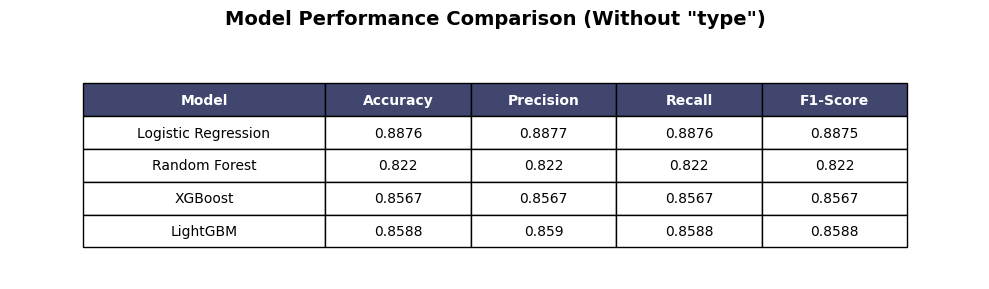

In [ ]:
# using ablation (removed the type column)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

le_model = LabelEncoder()
df['model'] = le_model.fit_transform(df['model'])

X_text = df['output']
y = df['model']

# Split dataset
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1)
}

results = []

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

results_df = pd.DataFrame(results).round(4)

print("\n" + "="*70)
print("MODEL COMPARISON RESULTS (WITHOUT 'type')")
print("="*70)
print(results_df.to_string(index=False))
print("="*70)

fig, ax = plt.subplots(figsize=(10, 3))
ax.axis('tight')
ax.axis('off')
table = ax.table(
    cellText=results_df.values,
    colLabels=results_df.columns,
    cellLoc='center',
    loc='center',
    colWidths=[0.25, 0.15, 0.15, 0.15, 0.15]
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

for i in range(len(results_df.columns)):
    table[(0, i)].set_facecolor('#40466e')
    table[(0, i)].set_text_props(weight='bold', color='white')

plt.title('Model Performance Comparison (Without "type")', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()



🎲 Running Randomized Search for Logistic Regression...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Best Params for Logistic Regression: {'C': np.float64(4.468327528535911), 'solver': 'lbfgs'}

MODEL COMPARISON RESULTS (After Randomized Search CV)
              Model                                 Best Params  Accuracy  Precision  Recall  F1-Score
Logistic Regression {'C': 4.468327528535911, 'solver': 'lbfgs'}    0.8912     0.8913  0.8912    0.8912


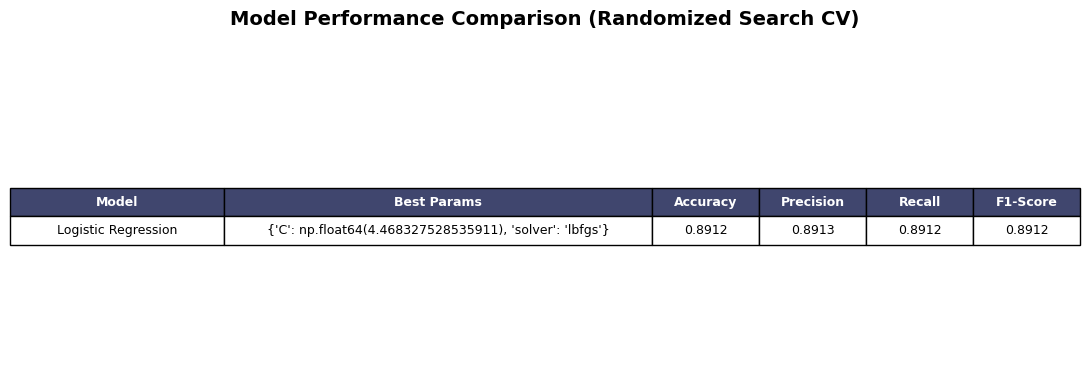

In [82]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from scipy.sparse import hstack
import matplotlib.pyplot as plt

le_type = LabelEncoder()
df['type'] = le_type.fit_transform(df['type'])

le_model = LabelEncoder()
df['model'] = le_model.fit_transform(df['model'])

X_text = df['output']
X_type = df['type']
y = df['model']

X_train_text, X_test_text, X_train_type, X_test_type, y_train, y_test = train_test_split(
    X_text, X_type, y, test_size=0.2, random_state=42, stratify=y
)

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)

X_train = hstack([X_train_tfidf, X_train_type.values.reshape(-1, 1)])
X_test = hstack([X_test_tfidf, X_test_type.values.reshape(-1, 1)])


from scipy.stats import uniform, randint

models = {
    'Logistic Regression': (
        LogisticRegression(max_iter=1000, random_state=42),
        {
            'C': uniform(0.01, 10),
            'solver': ['lbfgs', 'saga']
        }
    )
}


scorer = make_scorer(f1_score, average='weighted')
results = []

for name, (model, param_dist) in models.items():
    print(f"\n🎲 Running Randomized Search for {name}...")
    
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=10,           # number of random combos to test
        scoring=scorer,
        cv=3,                # fewer folds to save RAM/time
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    
    random_search.fit(X_train, y_train)
    
    print(f"✅ Best Params for {name}: {random_search.best_params_}")
    
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    results.append({
        'Model': name,
        'Best Params': random_search.best_params_,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })


results_df = pd.DataFrame(results)
results_df = results_df.round(4)

print("\n" + "="*80)
print("MODEL COMPARISON RESULTS (After Randomized Search CV)")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)


fig, ax = plt.subplots(figsize=(11, 4))
ax.axis('tight')
ax.axis('off')
table = ax.table(
    cellText=results_df.values, 
    colLabels=results_df.columns,
    cellLoc='center', 
    loc='center',
    colWidths=[0.2, 0.4, 0.1, 0.1, 0.1, 0.1]
)
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.6)

for i in range(len(results_df.columns)):
    table[(0, i)].set_facecolor('#40466e')
    table[(0, i)].set_text_props(weight='bold', color='white')

plt.title('Model Performance Comparison (Randomized Search CV)', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()



🎲 Running Randomized Search for Logistic Regression...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

MODEL COMPARISON RESULTS (Randomized Search CV, No 'type')
              Model                                 Best Params  Accuracy  Precision  Recall  F1-Score
Logistic Regression {'C': 4.468327528535911, 'solver': 'lbfgs'}    0.8902     0.8903  0.8902    0.8902


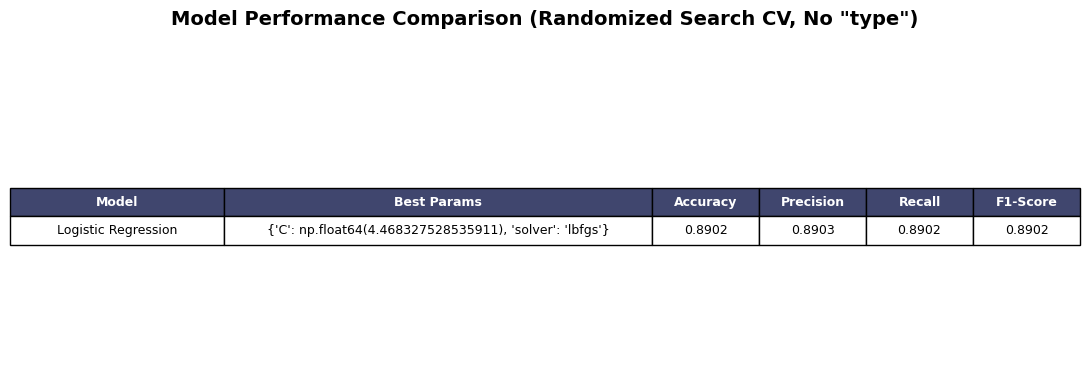

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt


le_model = LabelEncoder()
df['model'] = le_model.fit_transform(df['model'])

X_text = df['output']
y = df['model']

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)


models = {
    'Logistic Regression': (
        LogisticRegression(max_iter=1000, random_state=42),
        {'C': uniform(0.01, 10), 'solver': ['lbfgs', 'saga']}
    )
}


scorer = make_scorer(f1_score, average='weighted')
results = []

for name, (model, param_dist) in models.items():
    print(f"\n🎲 Running Randomized Search for {name}...")

    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=10,
        scoring=scorer,
        cv=3,
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    
    random_search.fit(X_train_tfidf, y_train)
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test_tfidf)

    results.append({
        'Model': name,
        'Best Params': random_search.best_params_,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1-Score': f1_score(y_test, y_pred, average='weighted')
    })

results_df = pd.DataFrame(results).round(4)

print("\n" + "="*90)
print("MODEL COMPARISON RESULTS (Randomized Search CV, No 'type')")
print("="*90)
print(results_df.to_string(index=False))
print("="*90)

fig, ax = plt.subplots(figsize=(11, 4))
ax.axis('tight')
ax.axis('off')
table = ax.table(
    cellText=results_df.values,
    colLabels=results_df.columns,
    cellLoc='center',
    loc='center',
    colWidths=[0.2, 0.4, 0.1, 0.1, 0.1, 0.1]
)
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.6)

for i in range(len(results_df.columns)):
    table[(0, i)].set_facecolor('#40466e')
    table[(0, i)].set_text_props(weight='bold', color='white')

plt.title('Model Performance Comparison (Randomized Search CV, No "type")', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib

le_type = LabelEncoder()
df['type'] = le_type.fit_transform(df['type'])

le_model = LabelEncoder()
df['model'] = le_model.fit_transform(df['model'])

X_text = df['output']
X_type = df['type']
y = df['model']

X_train_text, X_test_text, X_train_type, X_test_type, y_train, y_test = train_test_split(
    X_text, X_type, y, test_size=0.2, random_state=42, stratify=y
)

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)

X_train = np.hstack([X_train_tfidf.toarray(), X_train_type.values.reshape(-1, 1)])
X_test = np.hstack([X_test_tfidf.toarray(), X_test_type.values.reshape(-1, 1)])

print("Training Logistic Regression with best parameters...")
best_model = LogisticRegression(
    C=4.468327528535911, 
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\n" + "="*70)
print("BEST MODEL RESULTS - Logistic Regression")
print("="*70)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print("="*70)

print("\nSaving model and preprocessing objects...")
joblib.dump(best_model, 'logistic_regression_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(le_type, 'label_encoder_type.pkl')
joblib.dump(le_model, 'label_encoder_model.pkl')

print("✓ Model saved as: logistic_regression_model.pkl")
print("✓ Vectorizer saved as: tfidf_vectorizer.pkl")
print("✓ Type encoder saved as: label_encoder_type.pkl")
print("✓ Model encoder saved as: label_encoder_model.pkl")

print("\n" + "="*70)
print("LOADING MODEL EXAMPLE")
print("="*70)
print("To load and use the model later:")
print("""
# Load the saved objects
model = joblib.load('logistic_regression_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')
le_type = joblib.load('label_encoder_type.pkl')
le_model = joblib.load('label_encoder_model.pkl')

# Make predictions on new data
# new_text = ["your text here"]
# new_type = [0]  # encoded type value
# X_new_tfidf = vectorizer.transform(new_text)
# X_new = np.hstack([X_new_tfidf.toarray(), np.array(new_type).reshape(-1, 1)])
# prediction = model.predict(X_new)
# predicted_model = le_model.inverse_transform(prediction)
""")
print("="*70)

Training Logistic Regression with best parameters...

BEST MODEL RESULTS - Logistic Regression
Accuracy:  0.8913
Precision: 0.8914
Recall:    0.8913
F1-Score:  0.8913

Saving model and preprocessing objects...
✓ Model saved as: logistic_regression_model.pkl
✓ Vectorizer saved as: tfidf_vectorizer.pkl
✓ Type encoder saved as: label_encoder_type.pkl
✓ Model encoder saved as: label_encoder_model.pkl

LOADING MODEL EXAMPLE
To load and use the model later:

# Load the saved objects
model = joblib.load('logistic_regression_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')
le_type = joblib.load('label_encoder_type.pkl')
le_model = joblib.load('label_encoder_model.pkl')

# Make predictions on new data
# new_text = ["your text here"]
# new_type = [0]  # encoded type value
# X_new_tfidf = vectorizer.transform(new_text)
# X_new = np.hstack([X_new_tfidf.toarray(), np.array(new_type).reshape(-1, 1)])
# prediction = model.predict(X_new)
# predicted_model = le_model.inverse_transform(predi